# Quora From Scratch

Here I'll be having a fresh look at the Quora Questions problem now that I've been away from the problem for a while.

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn; seaborn.set()

In [14]:
quora = pd.read_csv('Data\\train.csv', encoding='utf-8', index_col=0)

In [15]:
quora.head()

,qid1,qid2,question1,question2,is_duplicate,similarity
id,,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.996546
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.934446
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.931912
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.740894
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.880832


I want to come up with a quick + dirty way to start off with the problem (that does better than chance). Probably using some minimal tokenization, scikit-learn and string similarity metrics.

I guess the easiest way to define 'better than chance' then is to start defining some metrics:

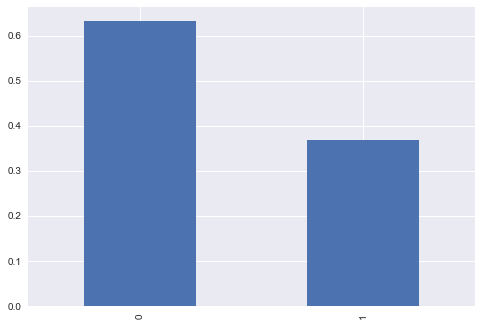

In [4]:
(quora.is_duplicate.value_counts()/len(quora)).plot(kind='bar')

In [5]:
duplicate_counts = quora.is_duplicate.value_counts()
print("There are %d 0s (%.2f%%) and %d (%.2f%%) 1s in the dataset"
      %(duplicate_counts[0], duplicate_counts[0]/len(quora)*100,
        duplicate_counts[1], duplicate_counts[1]/len(quora)*100))

There are 178665 0s (63.13%) and 104338 (36.87%) 1s in the dataset


So by chance, any model will achieve ~63% accuracy just by guessing 0 for all of the examples. We want to avoid this.

In [6]:
len(quora)

283003

## Processing with Spacy

We start off by loading spacy and the english language model

In [7]:
import spacy

In [8]:
nlp = spacy.load("en")

Next, we can compute a string similarity metric between each of the questions in the corpus. We can try using this as a starting point for comparisons.

In [9]:
def string_similarity(col1, col2):
    '''Measures the string similarity between two columns of text data
       Returns a column of similarity values'''
    
    col1 = nlp.pipe(map(lambda s: str(s).lower(), col1),
                    tag=False,
                    entity=False,
                    n_threads=3)
    col2 = nlp.pipe(map(lambda s: str(s).lower(), col2),
                    tag=False,
                    entity=False,
                    n_threads=3)
    
    for col1, col2 in zip(col1, col2):
        yield col1.similarity(col2)

In [10]:
# quora['similarity'] = list(string_similarity(quora.question1, quora.question2))

In [11]:
quora[quora.similarity == 0].head()

,qid1,qid2,question1,question2,is_duplicate,similarity
id,,,,,,
216861,323090,17986,Aaas,My dad always yells at me and causes me anxiet...,0,0.0
109009,178981,178982,How do I make a box that I can put my phone in...,Hh,0,0.0
20072,37898,37899,How could I solve this?,…………..,0,0.0
16619,31672,31673,Can we mention the sc/st scholarship provided ...,Tyrone st.ours,0,0.0
301583,424494,424495,…..,What do I do with this guy?,0,0.0


In [13]:
quora.ix[np.logical_and(np.array(quora.similarity > 0.999), np.array(quora.is_duplicate == 1)),:].head()

,qid1,qid2,question1,question2,is_duplicate,similarity
id,,,,,,
381512,27379,66488,What are the safety precautions on handling sh...,What are the safety precautions on handling sh...,1,1.0
42822,33378,77112,How can the drive from Edmonton to Auckland be...,How can the drive from Edmonton to Auckland be...,1,1.0
190971,290199,290200,What qualification do you need for a nursing job?,What qualifications do you need for a nursing ...,1,1.0
396679,25708,67593,What were the major effects of the cambodia ea...,What were the major effects of the cambodia ea...,1,1.0
22818,42793,42794,Why's playing snooker by myself (with other pe...,Why's playing snooker by myself (with other pe...,1,1.0


In [14]:
all_qs = sorted(set(quora.question1.append(quora.question2).astype('str')))

In [15]:
all_qs = list(nlp.pipe(all_qs, n_threads=3))

In [24]:
clusters = {}
for q in all_qs:
    for token in q:
        try:
            if token.text not in clusters[token.cluster]:
                clusters[token.cluster].append(token.text)
        except KeyError:
            clusters[token.cluster] = [token.text]

In [36]:
for i in range(max(clusters.keys())):
    try:
        print("%d: " %i, clusters[i][:10])
    except KeyError:
        continue

0:  [' ', '(', 'B.Ed', ')', '?', 'PayPal', 'Gopalasamy', 'Vaiko', 'Blackthorn', 'Kieran']
1:  ['vice']
2:  ['billion', 'A.M', 'cetera', 'P.M', 'a.m.', 'trillion', 'a.m', 'ppm', 'billon', 'p.m.']
3:  ['an', 'WORKFORCE']
4:  [',']
5:  ['increase', 'uptick']
6:  ['kg', 'Co', 'CO', 'Co.', 'Kg', 'KG', 'mfg', 'co.', 'Signatures', 'Flax']
7:  ['major']
8:  ['.']
9:  ['company', 'pope', 'taxman', 'Saxons', 'Divisor', 'IBA', 'comany']
10:  ['become', 'undergone']
11:  ['the', 'retaking']
12:  ['to']
13:  ['chats', 'talks', 'interviews', 'fights', 'fasts', 'agreements', 'dialogues', 'apprenticeships', 'discussions', 'meetings']
14:  ["''", 'Appear']
15:  ['two', 'uncountable', 'sixty', 'magma', '80-hour', 'fifty', 'inflammable']
17:  ['Sept', 'Dec.', 'aug', 'Sept.', 'Oct', 'Nov', 'feb', 'oct', 'Aug', 'Aug.']
18:  ['$', '#', 'Proposition', 'EXL']
19:  ['a']
20:  ['and', 'and/or', 'cum', 'profiling', 'CUM', 'Profiling']
21:  ['perimeter', 'wake', 'end', 'expiry', 'brink', 'verge', 'mastermind', 'e

In [37]:
import spacy
nlp = spacy.load('en')
doc = nlp(u'I like green eggs and ham.')
for np in doc.noun_chunks:
    print(np.text, np.root.text, np.root.dep_, np.root.head.text)
    # I I nsubj like
    # green eggs eggs dobj like
    # ham ham conj eggs

I I nsubj like
green eggs eggs dobj like
ham ham conj eggs


In [38]:
apples = nlp(u'bright red apples on the tree')[2]
print([w.text for w in apples.lefts])
# ['bright', 'red']
print([w.text for w in apples.rights])
# ['on']
assert apples.n_lefts == 2
assert apples.n_rights == 1

['bright', 'red']
['on']


In [44]:
from spacy.symbols import nsubj
doc = nlp(u'Credit and mortgage account holders must submit their requests within 30 days.')
root = [w for w in doc if w.head is w][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    print(descendant)

Credit
and
mortgage
account
holders


In [40]:
from spacy.symbols import nsubj
doc = nlp(u'Credit and mortgage account holders must submit their requests.')
holders = doc[4]
span = doc[holders.left_edge.i : holders.right_edge.i + 1]
span.merge()
for word in doc:
    print(word.text, word.pos_, word.dep_, word.head.text)
    # Credit and mortgage account holders nsubj NOUN submit
    # must VERB aux submit
    # submit VERB ROOT submit
    # their DET det requests
    # requests NOUN dobj submit

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their ADJ poss requests
requests NOUN dobj submit
. PUNCT punct submit


The plan is to fit curves to each of the distributions below and use them for bayesian inference.

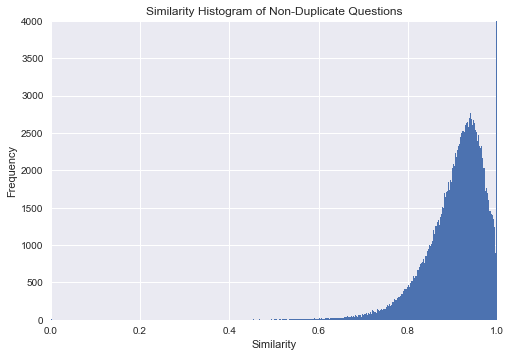

In [248]:
quora.ix[quora.is_duplicate==0, 'similarity'].hist(bins=500)
plt.title("Similarity Histogram of Non-Duplicate Questions")
plt.xlim(0,1)
plt.ylim(0,4000)
plt.xlabel('Similarity')
plt.ylabel('Frequency')

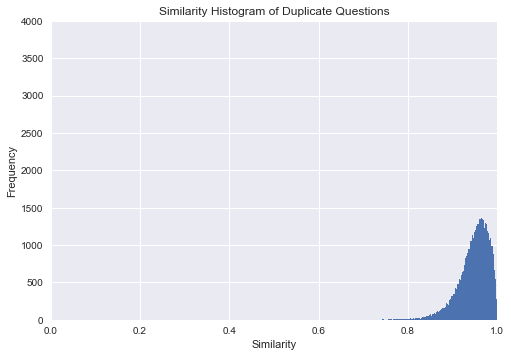

In [250]:
quora.ix[quora.is_duplicate==1, 'similarity'].hist(bins=500)
plt.title("Similarity Histogram of Duplicate Questions")
plt.xlim(0,1)
plt.ylim(0, 4000)
plt.xlabel('Similarity')
plt.ylabel('Frequency')

In [85]:
np.sum(quora.similarity < 0.85) / len(quora)

0.10959601134970301

## Predicting with scikit-learn

In [174]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [202]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, 
      min_samples_split=2, random_state=0, n_jobs=3)

In [207]:
scores = cross_val_score(clf, 
                         quora.similarity.values.reshape(-1,1),
                         quora.is_duplicate)
scores.mean()

0.61455178908165065